<p align="center">
  <img align="center" width="130" height="80" src="https://upload.wikimedia.org/wikipedia/commons/3/31/Boston_University_wordmark.svg">
</p>

<h5 align="center">MET CS 777 - Big Data Analytics</h5>
<h6 align="center">Fall 2021</h6>

<h2 align="center"> Natural Language Processing with pyspark </h2>
<h2 align="center"> Disaster Tweets classification </h2>

<h3 align="center"> Part 1 </h3>

### Project description 
predicting whether a given tweet is about a real disaster or not using pySpark by using ml libraries and by my own implementations 


Source : https://www.kaggle.com/c/nlp-getting-started/data

### Files     
train.csv - the training set
test.csv - the test set

### Columns
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [4]:
from utils.plots import *
from utils.prep_ml import *
from utils.prep_rdd import *

## Dataset

In [5]:
tweet = pd.read_csv('./nlp-getting-started/train.csv')
tweet_test = pd.read_csv('./nlp-getting-started/test.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# Dropping extra columns 
tweet= tweet[['id','text','target']]
tweet.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


## Data visualization

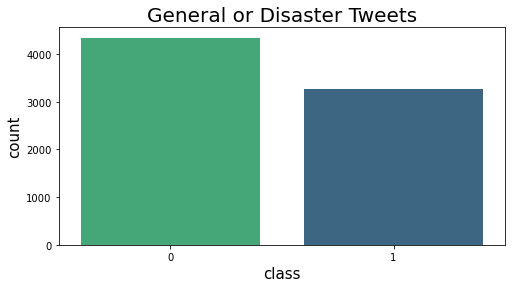

In [8]:
count_plot(tweet)

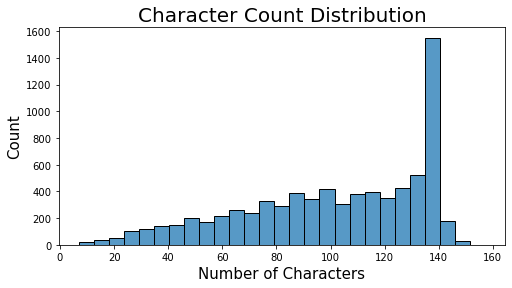

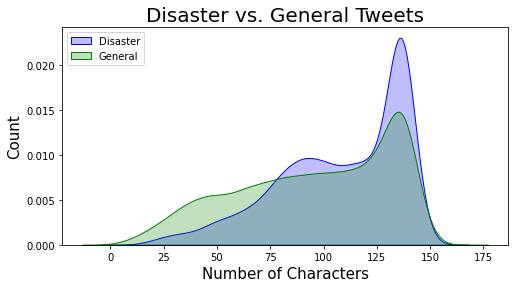

In [9]:
hist_plot(tweet , 'char' )

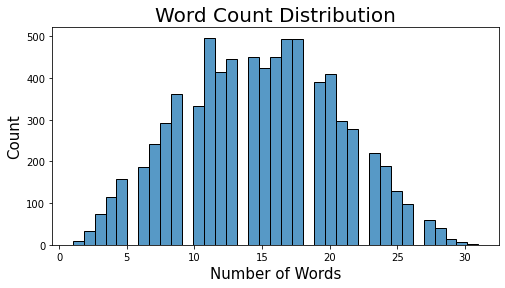

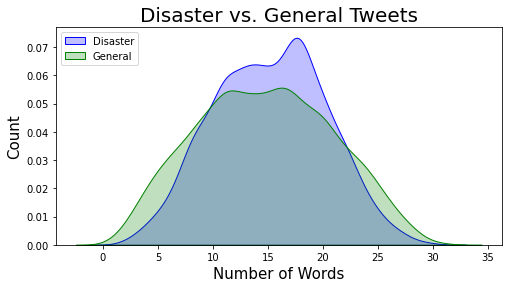

In [10]:
hist_plot(tweet , 'word' )

## Create Spark DataFrame from Pandas

In [7]:
from pyspark import SparkConf,SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType,StructField, StringType, IntegerType ,ArrayType
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName('tweet').getOrCreate()


#Custom Schema using StructType
mySchema = StructType([ StructField("id", StringType(), True)\
                       ,StructField("text", StringType(), True)\
                       ,StructField("class", StringType(), True)])

sparkDF=spark.createDataFrame(tweet, mySchema) 
sparkDF.printSchema()
sparkDF.show()


root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- class: string (nullable = true)

+---+--------------------+-----+
| id|                text|class|
+---+--------------------+-----+
|  1|Our Deeds are the...|    1|
|  4|Forest fire near ...|    1|
|  5|All residents ask...|    1|
|  6|13,000 people rec...|    1|
|  7|Just got sent thi...|    1|
|  8|#RockyFire Update...|    1|
| 10|#flood #disaster ...|    1|
| 13|I'm on top of the...|    1|
| 14|There's an emerge...|    1|
| 15|I'm afraid that t...|    1|
| 16|Three people died...|    1|
| 17|Haha South Tampa ...|    1|
| 18|#raining #floodin...|    1|
| 19|#Flood in Bago My...|    1|
| 20|Damage to school ...|    1|
| 23|      What's up man?|    0|
| 24|       I love fruits|    0|
| 25|    Summer is lovely|    0|
| 26|   My car is so fast|    0|
| 28|What a goooooooaa...|    0|
+---+--------------------+-----+
only showing top 20 rows



In [8]:
sparkDF.groupBy('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    0| 4342|
|    1| 3271|
+-----+-----+



## Preprocessing
### Using user defined functions and library

In [7]:
sparkDF = sparkDF.withColumn("clean", cleanup(f.col("text")))

sparkDF = sparkDF.withColumn('length', length(sparkDF['clean']))
sparkDF.withColumn("count", f.lit(1))\
    .groupby("class").agg({'length': 'mean'}).show()

+-----+-----------------+
|class|      avg(length)|
+-----+-----------------+
|    0|79.06264394288347|
|    1|87.44053806175482|
+-----+-----------------+



In [8]:
tokenizer = Tokenizer(inputCol="clean", outputCol="token_text")
tokenized = tokenizer.transform(sparkDF)

tokenized_df= tokenized.withColumn("tokens", countTokens(f.col("token_text")))

remover = StopWordsRemover(inputCol="token_text", outputCol="filtered")
tokenized_df = remover.transform(tokenized_df)

tokenized_df  = tokenized_df.withColumn("filteredmore", cleanstopwords(f.col("filtered")))

tokenized_df= tokenized_df.withColumn("filtered_tokens", countTokens(f.col("filteredmore")))

tokenized_df.show()

+---+--------------------+-----+--------------------+------+--------------------+------+--------------------+--------------------+---------------+
| id|                text|class|               clean|length|          token_text|tokens|            filtered|        filteredmore|filtered_tokens|
+---+--------------------+-----+--------------------+------+--------------------+------+--------------------+--------------------+---------------+
|  1|Our Deeds are the...|    1|our deeds are the...|    69|[our, deeds, are,...|    14|[deeds, reason, ,...|[deeds, reason, ,...|              8|
|  4|Forest fire near ...|    1|forest fire near ...|    38|[forest, fire, ne...|     8|[forest, fire, ne...|[forest, fire, ne...|              8|
|  5|All residents ask...|    1|all residents ask...|   133|[all, residents, ...|    25|[residents, asked...|[residents, asked...|             14|
|  6|13,000 people rec...|    1|people receive  w...|    58|[people, receive,...|     8|[people, receive,...|[people, 

## Number of words in each group

In [11]:
tokenized_df.groupby("class").agg({'tokens': 'mean'}).show()

+-----+------------------+
|class|       avg(tokens)|
+-----+------------------+
|    0|16.797328420082913|
|    1| 17.73800061143381|
+-----+------------------+



In [12]:
tokenized_df.groupby("class").agg({'filtered_tokens': 'mean'}).show()

+-----+--------------------+
|class|avg(filtered_tokens)|
+-----+--------------------+
|    0|  11.324965453707968|
|    1|  13.161112809538368|
+-----+--------------------+



In [19]:
# I don't know the reason but reading the data using spark is okay in notebook but will cause problem in python script. Because of that I read the csv using pandas and hen convert it to Spark Datafraem
data = spark.read.csv('./nlp-getting-started/train.csv' ,inferSchema=True,header=True)
data.select(f.col("id"),f.col("text"),f.col("target").alias("class")).show()

### Using library and Pipeline 

In [9]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover, CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline


count_vec = CountVectorizer(inputCol='filteredmore',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
tweet_class = StringIndexer(inputCol='class',outputCol='label')
vector = VectorAssembler(inputCols=['tf_idf','filtered_tokens'],outputCol='features')

data_prep_pipe = Pipeline(stages=[tweet_class,count_vec,idf,vector])
prep = data_prep_pipe.fit(tokenized_df)

dataset = prep.transform(tokenized_df)
dataset = dataset.select(['label','features'])

(training,testing) = dataset.randomSplit([0.8,0.2])

In [14]:
training.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(13893,[0,1,3,146...|
|  0.0|(13893,[0,1,43,81...|
|  0.0|(13893,[0,1,112,2...|
|  0.0|(13893,[0,2,6,145...|
|  0.0|(13893,[0,2,9,24,...|
|  0.0|(13893,[0,2,11,31...|
|  0.0|(13893,[0,2,28,60...|
|  0.0|(13893,[0,2,31,77...|
|  0.0|(13893,[0,2,31,77...|
|  0.0|(13893,[0,2,31,82...|
|  0.0|(13893,[0,2,31,14...|
|  0.0|(13893,[0,2,35,60...|
|  0.0|(13893,[0,2,40,42...|
|  0.0|(13893,[0,2,63,71...|
|  0.0|(13893,[0,2,523,5...|
|  0.0|(13893,[0,2,523,6...|
|  0.0|(13893,[0,4,24,59...|
|  0.0|(13893,[0,4,32,46...|
|  0.0|(13893,[0,4,59,14...|
|  0.0|(13893,[0,4,60,67...|
+-----+--------------------+
only showing top 20 rows



## Using libraries for classification 
* Since the test set does not have any label I split the training set to train and test 

* NaiveBayes
* Logistic Regression 
* SVM
* DecisionTree
* Random Forest
* GBT - Gradient Boosted Tree


## NaiveBayes Using Library

In [ ]:
!python NaiveBayes.py './nlp-getting-started/train.csv'

============== Results: ==============
    
Accuracy of model was: %78.41

f1 score of model was: %78.4

- Train time = 4.5829

- Test time = 0.0354

- Total time = 4.6183

## Logistic Regression Using Library

### Testing diffrent regparam

In [22]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
regparam = [0.0001, 0.001,0.01,0.1,1,10]
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')

for param in regparam:
    lr_model = LogisticRegression(labelCol='label',regParam=param)
    fitted_lr_model = lr_model.fit(training)
    test_results = fitted_lr_model.transform(testing)
    acc = evaluator.evaluate(test_results, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(test_results, {evaluator.metricName: "f1"})
    
    print(f"regparam = {param} , Acc: {round(acc, 4)*100} , f1 = {round(f1, 4)*100} ")

    

regparam = 0.0001 , Acc: 74.56 , f1 = 74.53 
regparam = 0.001 , Acc: 75.81 , f1 = 75.71 
regparam = 0.01 , Acc: 77.57 , f1 = 77.39 
regparam = 0.1 , Acc: 77.82 , f1 = 77.47 
regparam = 1 , Acc: 78.38000000000001 , f1 = 77.45 
regparam = 10 , Acc: 65.60000000000001 , f1 = 57.65 


In [ ]:
!python LogisticRegression.py './nlp-getting-started/train.csv'

============== Results: ==============

Accuracy of model was: %79.16

f1 score of model was: %78.2

- Train time = 6.698

- Test time = 0.0311

- Total time = 6.7291

## SVM Using Library 

### Testing diffrent regparam

In [53]:
from pyspark.ml.classification import LinearSVC
regparam = [0.0001, 0.001,0.01,0.1,1,10]

for param in regparam:
    svm_model = LinearSVC( maxIter=100, regParam=param)
    fitted_svm_model = svm_model.fit(training)
    test_results = fitted_svm_model.transform(testing)
    acc = evaluator.evaluate(test_results, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(test_results, {evaluator.metricName: "f1"})
    
    print(f"regparam = {param} , Acc: {round(acc, 4)*100} , f1 = {round(f1, 4)*100} ")

regparam = 0.0001 , Acc: 76.31 , f1 = 76.19 
regparam = 0.001 , Acc: 76.31 , f1 = 76.2 
regparam = 0.01 , Acc: 76.25 , f1 = 76.14 
regparam = 0.1 , Acc: 77.22 , f1 = 77.09 
regparam = 1 , Acc: 77.73 , f1 = 77.51 
regparam = 10 , Acc: 60.91 , f1 = 48.209999999999994 


In [ ]:
!python SVM.py './nlp-getting-started/train.csv'

============== Results: ==============

Accuracy of model was: %78.02

f1 score of model was: %77.60000000000001

- Train time = 44.4904

- Test time = 0.0226

- Total time = 44.513

### Trees Using Library

* DecisionTree
* Random Forest
* GBT - Gradient Boosted Tree

In [ ]:
!python Trees.py './nlp-getting-started/train.csv'

============== DecisionTree ==============

Accuracy of model was: %60.629999999999995

f1 score of model was: %49.9

- Train time = 12.4768

- Test time = 0.0373

- Total time = 12.5141

============== Random Forest ==============

Accuracy of model was: %62.09

f1 score of model was: %52.300000000000004

- Train time = 5.0317

- Test time = 0.0377

- Total time = 5.0694

============== GBT ==============

Accuracy of model was: %73.45

f1 score of model was: %71.5

- Train time = 39.5754

- Test time = 0.0539

- Total time = 39.6293


In [10]:
training.take(1)

[Row(label=0.0, features=SparseVector(13893, {0: 0.679, 1: 3.1326, 3: 3.4824, 144: 5.0059, 228: 5.1765, 340: 5.3542, 817: 5.9933, 1077: 6.2987, 3804: 7.5514, 5236: 7.8391, 5683: 7.8391, 9640: 8.2446, 13892: 13.0}))]

## Convert dataframe to RDD

In [17]:
small_df = sparkDF.select('id','text','class')
RDD = small_df.rdd
RDD = RDD.map(lambda x: (x[0],x[2],x[1]))
RDD.take(2)

[('1',
  '1',
  'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'),
 ('4', '1', 'Forest fire near La Ronge Sask. Canada')]

In [11]:
RDD.count()

7613

## Creating the words dictionary

In [18]:
def get_dict(keyAndListOfWords):
    """make a 1000 words dictionary"""
    allWords = keyAndListOfWords.flatMap(lambda x: (x[2])).map(lambda x: (x, 1))
    allCounts = allWords.reduceByKey(lambda x,y: x + y) # I will use lambda instead of add maybe it would be faster in spark 
    topWords = allCounts.top(10000, key= lambda x: x[1])
    topWordsK = sc.parallelize(range(10000))
    dictionary = topWordsK.map(lambda x : (topWords[x][0], x))
    return dictionary

In [19]:
keyAndListOfWords =  RDD.map(lambda x : (x[0],x[1],word_tokenizer(x[2]) ))
numberOftweets = RDD.count()

dictionary = get_dict(keyAndListOfWords)

In [32]:
print(dictionary.take(20))

[('fire', 0), ('like', 1), ('get', 2), ('news', 3), ('people', 4), ('time', 5), ('year', 6), ('video', 7), ('disaster', 8), ('emergency', 9), ('body', 10), ('day', 11), ('home', 12), ('police', 13), ('building', 14), ('u', 15), ('family', 16), ('go', 17), ('life', 18), ('say', 19)]


## Creating the words dictionary for Disaster and Non-disaster 

In [29]:
disaster = keyAndListOfWords.filter(lambda x : x[1] =='1')
nondisaster = keyAndListOfWords.filter(lambda x : x[1] == '0')

disaster_dictionary = get_dict(disaster)
nondisaster_dictionary = get_dict(nondisaster)

In [33]:
print(disaster_dictionary.take(20))

[('fire', 0), ('news', 1), ('disaster', 2), ('california', 3), ('year', 4), ('suicide', 5), ('police', 6), ('people', 7), ('family', 8), ('home', 9), ('train', 10), ('storm', 11), ('killed', 12), ('building', 13), ('like', 14), ('hiroshima', 15), ('bomb', 16), ('crash', 17), ('pm', 18), ('flood', 19)]


In [34]:
print(nondisaster_dictionary.take(20))

[('like', 0), ('get', 1), ('body', 2), ('time', 3), ('day', 4), ('video', 5), ('love', 6), ('people', 7), ('go', 8), ('got', 9), ('know', 10), ('fire', 11), ('let', 12), ('back', 13), ('full', 14), ('see', 15), ('bag', 16), ('emergency', 17), ('want', 18), ('u', 19)]


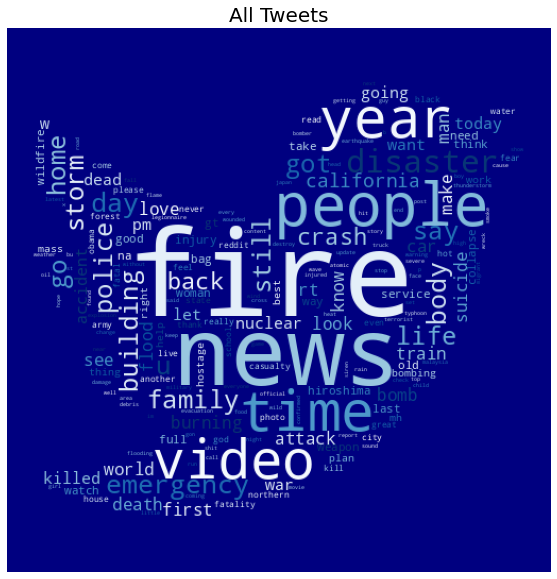

In [105]:
word_cloud(keyAndListOfWords, "All Tweets")

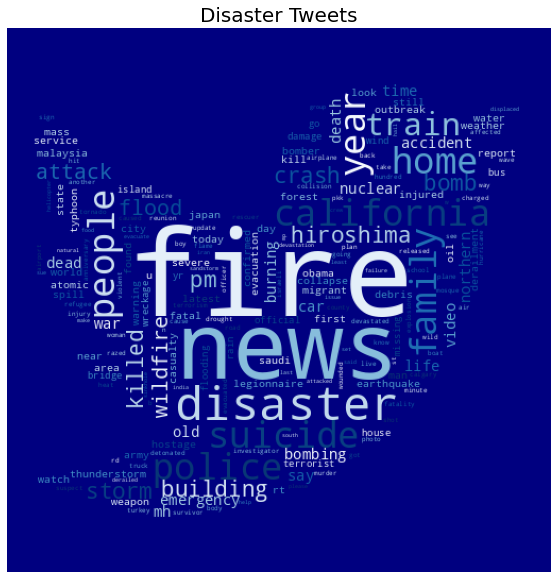

In [106]:
word_cloud(disaster, "Disaster Tweets")

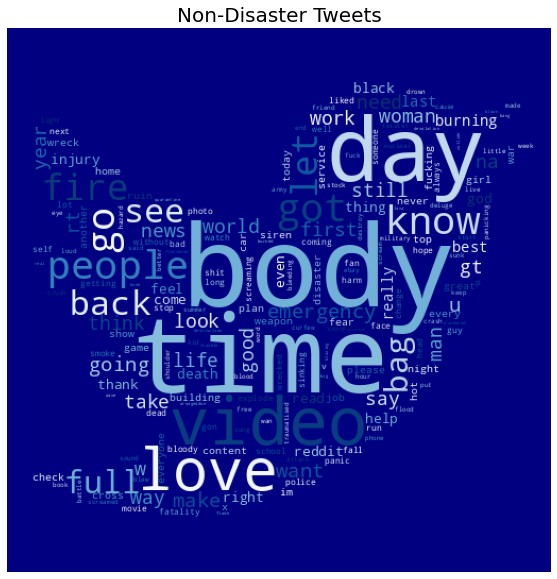

In [107]:
word_cloud(nondisaster, "Non-Disaster Tweets")

In [20]:
allDocsWithLabel = get_tfArray(keyAndListOfWords,dictionary)
tf_idfArray = get_tf_idfArray(allDocsWithLabel, numberOftweets)
training, testing = tf_idfArray.randomSplit([0.8, 0.2], seed=123)
print('Training data count', training.count())
print('Testing data count', testing.count())

Training data count 6096
Testing data count 1512


In [25]:
training.take(3)

[('10782', '1', array([0., 0., 0., ..., 0., 0., 0.])),
 ('4257',
  '0',
  array([0.        , 0.        , 0.34282243, ..., 0.        , 0.        ,
         0.        ])),
 ('4617', '0', array([0., 0., 0., ..., 0., 0., 0.]))]

## logistic_regression 
* Dictionary from all tweets

In [ ]:
coef, cost_array = logistic_regression(training,dictionary)

The top 5 words with largest coefficients:
['hiroshima', 'wildfire', 'bombing', 'derailment', 'pileq']

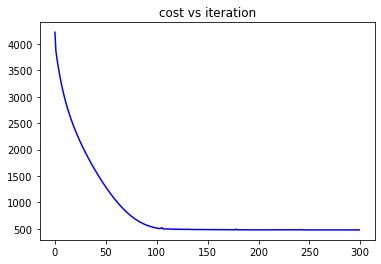

In [12]:
plot_cost(cost_array)

In [13]:
test_pred = testing.map(lambda x: prediction(x, coef))

In [14]:
test_pred = testing.map(lambda x: prediction(x, coef))
Pos_Neg = test_pred.map(lambda x :  t_f_Pos_Neg(x))

tp,tn,fp,fn = Pos_Neg.map(lambda x : (x[1],x[2],x[3],x[4])).reduce( lambda x,y :(x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))

f1 = tp / (tp + 0.5*(fp+fn))
acc = (tp+tn) / (tp+tn+fp+fn)


print("\n============== Results: ==============\n")
print("Accuracy of model was: %{0:2.2f}\n".format(acc*100))
print("f1 score of model was: %{0:2.2f}\n".format(f1*100))


============== Results: ==============

Accuracy of model was: %75.69

f1 score of model was: %71.94



In [ ]:
!python RDD_logisticregression.py './nlp-getting-started/train.csv' './output'

The top 5 words with largest coefficients:

----------------------------------------------------------------------------------------------------
['fire', 'california', 'train', 'hiroshima', 'wildfire']
                                                                                
============== Results: ==============

Accuracy of model was: %79.68

f1 score of model was: %75.34

- Train time = 57.3513

- Test time = 0.8978

In [ ]:
!python RDD_logisticregression.py './nlp-getting-started/train.csv' './output2'

['fire', 'california', 'train', 'hiroshima', 'wildfire']                        
                                                                                
============== Results: ==============

Accuracy of model was: %79.81

f1 score of model was: %75.50

- Train time = 308.5709

- Test time = 0.7384

## logistic_regression 
* Dictionary from Disaster tweets

In [ ]:
coef, cost_array = logistic_regression(training,disaster)

In [46]:
test_pred = testing.map(lambda x: prediction(x, coef))
Pos_Neg = test_pred.map(lambda x :  t_f_Pos_Neg(x))

tp,tn,fp,fn = Pos_Neg.map(lambda x : (x[1],x[2],x[3],x[4])).reduce( lambda x,y :(x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))

f1 = tp / (tp + 0.5*(fp+fn))
acc = (tp+tn) / (tp+tn+fp+fn)

print("\n============== Results: ==============\n")
print("Accuracy of model was: %{0:2.2f}\n".format(acc*100))
print("f1 score of model was: %{0:2.2f}\n".format(f1*100))


============== Results: ==============

Accuracy of model was: %79.25

f1 score of model was: %74.86



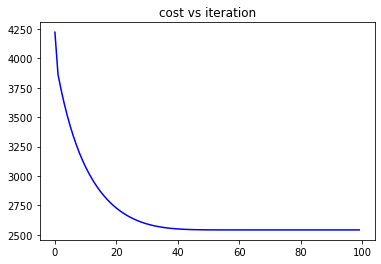

In [47]:
plot_cost(cost_array)

## SVM
* Dictionary from All tweets

In [ ]:
!python RDD_svm.py './nlp-getting-started/train.csv' './output_svm'

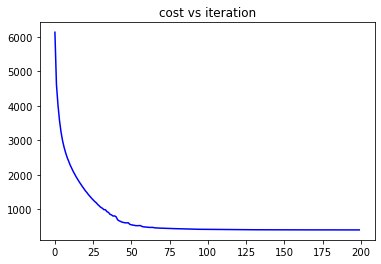

In [64]:
plot_output('./output_svm/part-00000')

## Logistic Regression with different Gradient Descent Optimizers

In [ ]:
!python LR_Optimizers.py './nlp-getting-started/train.csv' './optimizer:'

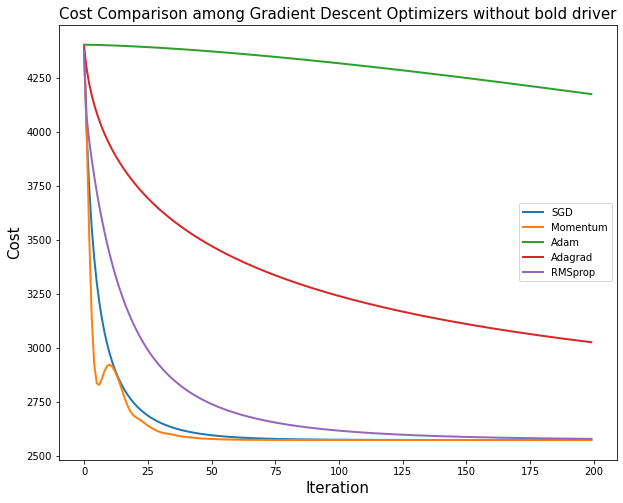

In [10]:
plot_cost_optimizer('./out/optimizer:', bold_driver = 'without', name ='./images/lr_wobd.png')

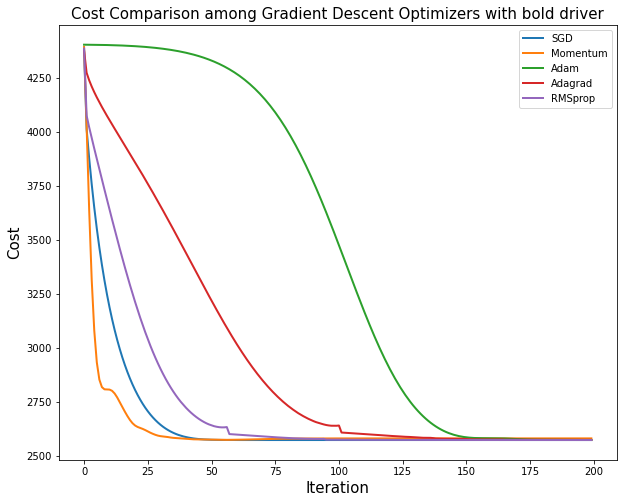

In [12]:
plot_cost_optimizer('./out/optimizer2:', bold_driver = 'with', name ='./images/lr_bd.png')

## SVM with different Gradient Descent Optimizers

In [ ]:
!python SVM_Optimizers.py './nlp-getting-started/train.csv' './out/optimizer3:'

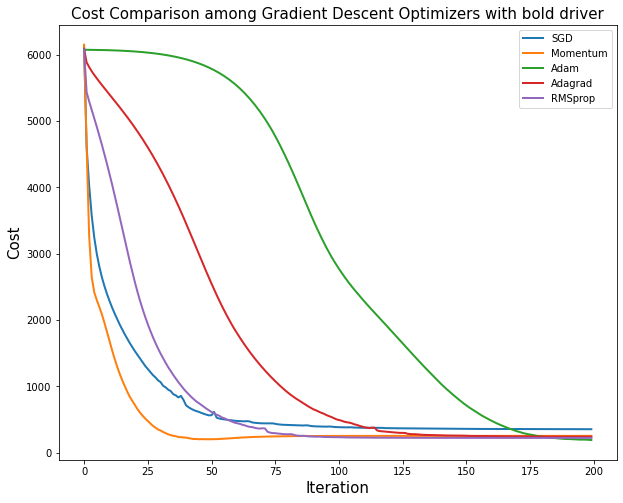

In [14]:
plot_cost_optimizer('./out/optimizer3:', bold_driver = 'with', name ='./images/svm_bd.png')

In [ ]:
!python SVM_Optimizers.py './nlp-getting-started/train.csv' './out/optimizer4_'

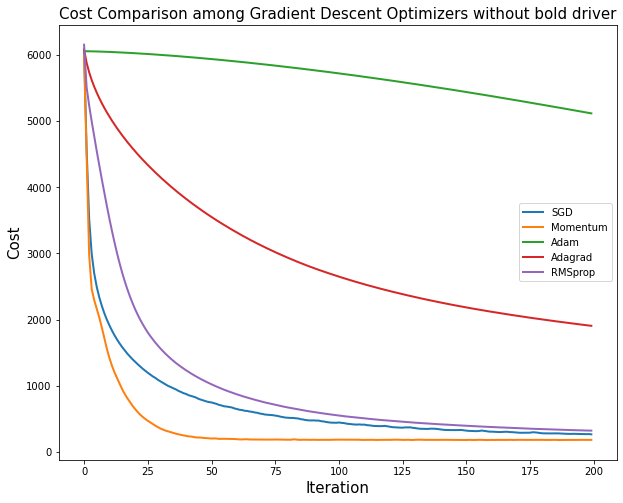

In [16]:
plot_cost_optimizer('./out/optimizer4_', bold_driver = 'without', name ='./images/svm_wobd.png')

# Continues in second Notebook